## Get names of colleges from Wikipedia

In [1]:
import numpy as np
import pandas as pd

import json
import requests

from geopy.geocoders import Nominatim

from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
from sklearn import metrics

!pip install yellowbrick
from yellowbrick.cluster import KElbowVisualizer

In [2]:
url = 'https://en.wikipedia.org/wiki/List_of_colleges_and_universities_in_Maryland'
tables = pd.read_html(url)

print(len(tables))

11


In [3]:
for i in range(len(tables)):
    print("Table at Index", i)
    print(tables[i].head(3))
    print('\n')

Table at Index 0
                         Name   Location  Founded Type  Enrollment  Ref
0      Bowie State University      Bowie     1865  USM        6171  [7]
1     Coppin State University  Baltimore     1900  USM        2724  [8]
2  Frostburg State University  Frostburg     1899  USM        4831  [9]


Table at Index 1
                                              Name    Location  Founded  \
0  University of Maryland, Biotechnology Institute   Baltimore     1985   
1    University of Maryland, Environmental Science   Cambridge     1925   
2      University System of Maryland at Hagerstown  Hagerstown     2008   

   Enrollment       Ref  
0        66.0      [23]  
1       129.0      [24]  
2         NaN  [25][26]  


Table at Index 2
                               Name    Location  Founded   Ref
0      Allegany College of Maryland  Cumberland     1961  [31]
1    Anne Arundel Community College      Arnold     1961  [32]
2  Baltimore City Community College   Baltimore     1947  [33]


In [4]:
public_df = tables[0]
private_df = tables[3]

print(public_df.head())
print(private_df.head())

                         Name   Location  Founded         Type  Enrollment  \
0      Bowie State University      Bowie     1865          USM        6171   
1     Coppin State University  Baltimore     1900          USM        2724   
2  Frostburg State University  Frostburg     1899          USM        4831   
3     Morgan State University  Baltimore     1867  Independent        6616   
4        Salisbury University  Salisbury     1925          USM        8617   

            Ref  
0           [7]  
1           [8]  
2           [9]  
3  [10][11][12]  
4          [13]  
                            Name   Location  Founded  Enrollment (2019)   Ref
0  Capitol Technology University     Laurel     1927                343  [47]
1                Goucher College     Towson     1885               2680  [48]
2                   Hood College  Frederick     1893               2052  [49]
3       Johns Hopkins University  Baltimore     1876              26402  [50]
4     Loyola University Maryland 

In [5]:
public_df = public_df.loc[:, ['Name', 'Location', 'Enrollment']]
type_col = []

college_list = public_df['Name']
for i in range(len(college_list)):
    type_col.append('Public')

public_df['Type'] = type_col
public_df.head(3)

,Name,Location,Enrollment,Type
0,Bowie State University,Bowie,6171,Public
1,Coppin State University,Baltimore,2724,Public
2,Frostburg State University,Frostburg,4831,Public


In [6]:
private_df = private_df.loc[:, ['Name', 'Location', 'Enrollment (2019)']]
private_df = private_df.rename(columns = {'Enrollment (2019)': 'Enrollment'})

type_col = []

college_list_2 = private_df['Name']
for i in range(len(college_list)):
    type_col.append('Private')

private_df['Type'] = type_col
private_df.head(3)

,Name,Location,Enrollment,Type
0,Capitol Technology University,Laurel,343,Private
1,Goucher College,Towson,2680,Private
2,Hood College,Frederick,2052,Private


In [7]:
print(public_df.shape)
print(private_df.shape)

(14, 4)
(14, 4)


In [8]:
colleges_df = public_df.append(private_df).reset_index(drop=True)
colleges_df.head()

,Name,Location,Enrollment,Type
0,Bowie State University,Bowie,6171,Public
1,Coppin State University,Baltimore,2724,Public
2,Frostburg State University,Frostburg,4831,Public
3,Morgan State University,Baltimore,6616,Public
4,Salisbury University,Salisbury,8617,Public


In [9]:
colleges_df.shape

(28, 4)

## Get the coordinates of each college

In [10]:
lats = []
lngs = []

geolocator = Nominatim(user_agent = "colleges")

for college, city in zip(colleges_df['Name'], colleges_df['Location']):
    address = college + ', ' + city + ', MD'
    location = geolocator.geocode(address)
    try:
        latitude = location.latitude
        longitude = location.longitude
    except:
        address = college + ', MD'
        location = geolocator.geocode(address)
        try:
            latitude = location.latitude
            longitude = location.longitude
            
        except:
            latitude = np.nan
            longitude = np.nan

    lats.append(round(latitude, 3))
    lngs.append(round(longitude, 3))

In [11]:
colleges_df['Latitude'] = lats
colleges_df['Longitude'] = lngs
colleges_df

,Name,Location,Enrollment,Type,Latitude,Longitude
0,Bowie State University,Bowie,6171,Public,39.018,-76.759
1,Coppin State University,Baltimore,2724,Public,39.311,-76.659
2,Frostburg State University,Frostburg,4831,Public,39.648,-78.941
3,Morgan State University,Baltimore,6616,Public,39.345,-76.584
4,Salisbury University,Salisbury,8617,Public,38.345,-75.607
5,St. Mary's College of Maryland,St. Mary's City,1849,Public,38.190,-76.425
6,Towson University,Towson,22709,Public,39.390,-76.616
7,United States Naval Academy,Annapolis,4400,Public,38.982,-76.483
8,University of Baltimore,Baltimore,4476,Public,39.305,-76.617
9,"University of Maryland, Baltimore",Baltimore,6827,Public,NaN,NaN


In [12]:
no_coordinates = colleges_df.loc[colleges_df['Latitude'].isna()]
no_coordinates

,Name,Location,Enrollment,Type,Latitude,Longitude
9,"University of Maryland, Baltimore",Baltimore,6827,Public,NaN,NaN
10,"University of Maryland, Baltimore County",Catonsville,13602,Public,NaN,NaN
13,University of Maryland Global Campus,Adelphi,58868,Public,NaN,NaN


In [13]:
new_lats = []
new_lngs = []

addresses = ["620 W Lexington St, Baltimore, MD 21201", "UMBC, Catonsville, MD", "University of Maryland University College"]

for address in addresses:
    location = geolocator.geocode(address)
    try:
        latitude = location.latitude
        longitude = location.longitude
    except:
        latitude = np.nan
        longitude = np.nan
    new_lats.append(round(latitude, 3))
    new_lngs.append(round(longitude, 3))

In [14]:
print(new_lats)

[39.292, 39.256, 38.992]


In [15]:
no_coordinates['Latitude'] = new_lats
no_coordinates['Longitude'] = new_lngs
no_coordinates

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,Name,Location,Enrollment,Type,Latitude,Longitude
9,"University of Maryland, Baltimore",Baltimore,6827,Public,39.292,-76.625
10,"University of Maryland, Baltimore County",Catonsville,13602,Public,39.256,-76.716
13,University of Maryland Global Campus,Adelphi,58868,Public,38.992,-76.946


In [16]:
colleges_final = colleges_df.loc[colleges_df['Latitude'].isna() == False]
colleges_final = pd.concat([colleges_final, no_coordinates]).reset_index(drop=True)
colleges_final

,Name,Location,Enrollment,Type,Latitude,Longitude
0,Bowie State University,Bowie,6171,Public,39.018,-76.759
1,Coppin State University,Baltimore,2724,Public,39.311,-76.659
2,Frostburg State University,Frostburg,4831,Public,39.648,-78.941
3,Morgan State University,Baltimore,6616,Public,39.345,-76.584
4,Salisbury University,Salisbury,8617,Public,38.345,-75.607
5,St. Mary's College of Maryland,St. Mary's City,1849,Public,38.190,-76.425
6,Towson University,Towson,22709,Public,39.390,-76.616
7,United States Naval Academy,Annapolis,4400,Public,38.982,-76.483
8,University of Baltimore,Baltimore,4476,Public,39.305,-76.617
9,"University of Maryland, College Park",College Park,40743,Public,38.992,-76.946


## Use Foursquare to get the list of venues

In [17]:
# The code was removed by Watson Studio for sharing.

In [18]:
names = colleges_final['Name']
cities = colleges_final['Location']
lats = colleges_final['Latitude']
lngs = colleges_final['Longitude']

radius = 500
limit = 100

venues = []

In [19]:
for college, city, lat, lng in zip(names, cities, lats, lngs):
    
    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        client_id,
        client_secret,
        version,
        lat,
        lng,
        radius,
        limit)
    
    results = requests.get(url).json()
    results = results['response']['groups'][0]['items']
    
    venues.append([(
            college,
            city,
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

In [20]:
college_venues = pd.DataFrame([item for venue_list in venues for item in venue_list])
college_venues.columns = ['Name', 'Location', 'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']
college_venues.head()

,Name,Location,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bowie State University,Bowie,Saxbys,39.017873,-76.758211,Coffee Shop
1,Bowie State University,Bowie,Sweet Chic Jewelry Store,39.019061,-76.757541,Jewelry Store
2,Bowie State University,Bowie,Bowie State University Fine & Performing Art C...,39.016102,-76.758926,College Arts Building
3,Bowie State University,Bowie,Legacy Design Studios,39.018876,-76.753328,Nightlife Spot
4,Coppin State University,Baltimore,Subway,39.310036,-76.658768,Sandwich Place


In [21]:
college_venues.groupby('Name').count()

,Location,Venue,Venue Latitude,Venue Longitude,Venue Category
Name,,,,,
Bowie State University,4,4,4,4,4
Coppin State University,2,2,2,2,2
Goucher College,5,5,5,5,5
Hood College,5,5,5,5,5
Johns Hopkins University,26,26,26,26,26
Loyola University Maryland,6,6,6,6,6
Maryland Institute College of Art,42,42,42,42,42
McDaniel College,1,1,1,1,1
Morgan State University,4,4,4,4,4


## Prepare data for clustering

In [22]:
colleges_onehot = pd.get_dummies(college_venues[['Venue Category']], prefix="", prefix_sep="")
colleges_onehot['Name'] = college_venues['Name']

fixed_columns = [colleges_onehot.columns[-1]] + list(colleges_onehot.columns[:-1])
colleges_onehot = colleges_onehot[fixed_columns]

colleges_onehot.head()

,Name,Afghan Restaurant,American Restaurant,Art Gallery,Arts & Crafts Store,Athletics & Sports,Auto Workshop,Bagel Shop,Bakery,Bar,...,Thai Restaurant,Theater,Tourist Information Center,Trail,Train Station,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint
0,Bowie State University,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Bowie State University,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Bowie State University,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Bowie State University,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Coppin State University,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
colleges_grouped = colleges_onehot.groupby('Name').mean().reset_index()
colleges_grouped.head()

,Name,Afghan Restaurant,American Restaurant,Art Gallery,Arts & Crafts Store,Athletics & Sports,Auto Workshop,Bagel Shop,Bakery,Bar,...,Thai Restaurant,Theater,Tourist Information Center,Trail,Train Station,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint
0,Bowie State University,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Coppin State University,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Goucher College,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0
3,Hood College,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Johns Hopkins University,0.0,0.038462,0.0,0.0,0.076923,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
for college in colleges_grouped['Name']:
    print(college)
    
    type_list = colleges_grouped[colleges_grouped['Name'] == college].T.reset_index()
    type_list.columns = ['Venue Type', 'Frequency']
    type_list = type_list.iloc[1:]
    
    type_list['Frequency'] = type_list['Frequency'].astype(float)
    type_list = type_list.round({'Frequency': 2})
    
    type_list = type_list.sort_values('Frequency', ascending=False).reset_index(drop=True)
    
    print(type_list.head(2))
    print('\n')

Bowie State University
       Venue Type  Frequency
0  Nightlife Spot       0.25
1     Coffee Shop       0.25


Coppin State University
             Venue Type  Frequency
0        Sandwich Place        0.5
1  Fast Food Restaurant        0.5


Goucher College
      Venue Type  Frequency
0      Disc Golf        0.2
1  College Track        0.2


Hood College
       Venue Type  Frequency
0        Pharmacy        0.2
1  Sandwich Place        0.2


Johns Hopkins University
  Venue Type  Frequency
0     Museum       0.08
1       Park       0.08


Loyola University Maryland
                 Venue Type  Frequency
0                Restaurant       0.17
1  College Basketball Court       0.17


Maryland Institute College of Art
    Venue Type  Frequency
0      Theater       0.10
1  Art Gallery       0.07


McDaniel College
          Venue Type  Frequency
0        Coffee Shop        1.0
1  Afghan Restaurant        0.0


Morgan State University
       Venue Type  Frequency
0      Food Stand       0.

In [25]:
num_types = 4

columns_list = ['Name']

for i in range(num_types):
    col_label = "Venue Category " + str(i + 1)
    columns_list.append(col_label)

top_venue_types = pd.DataFrame(columns=columns_list)
top_venue_types['Name'] = colleges_grouped['Name']

for i in range(colleges_grouped.shape[0]):
    row = colleges_grouped.iloc[i, :]
    categories = row.iloc[1:]
    sorted_categories = categories.sort_values(ascending=False)
    sorted_categories = sorted_categories.index.values[0:num_types]
    
    top_venue_types.iloc[i, 1:] = sorted_categories

top_venue_types.head()

,Name,Venue Category 1,Venue Category 2,Venue Category 3,Venue Category 4
0,Bowie State University,Jewelry Store,Nightlife Spot,Coffee Shop,College Arts Building
1,Coppin State University,Sandwich Place,Fast Food Restaurant,Wings Joint,Ethiopian Restaurant
2,Goucher College,College Track,Pool,Trail,Disc Golf
3,Hood College,Home Service,Fast Food Restaurant,Sandwich Place,Pharmacy
4,Johns Hopkins University,History Museum,Athletics & Sports,Museum,Café


In [26]:
colleges_clustering = colleges_grouped.drop('Name', 1)
colleges_clustering.head()

,Afghan Restaurant,American Restaurant,Art Gallery,Arts & Crafts Store,Athletics & Sports,Auto Workshop,Bagel Shop,Bakery,Bar,Baseball Field,...,Thai Restaurant,Theater,Tourist Information Center,Trail,Train Station,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint
0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.038462,0.0,0.0,0.076923,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Run K-Means Clustering

/opt/conda/envs/Python36/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


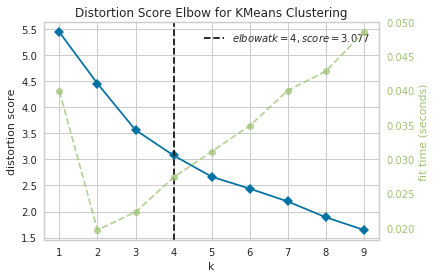

In [27]:
KMM = KMeans()
visualizer = KElbowVisualizer(KMM, k=(1, 10))
visualizer.fit(colleges_clustering)       
visualizer.show()

In [28]:
num_ks = 10
inertias = []

for k in range(1, num_ks):
    KMC = KMeans(n_clusters = k, random_state = 0).fit(colleges_clustering)
    inertias.append(KMC.inertia_)

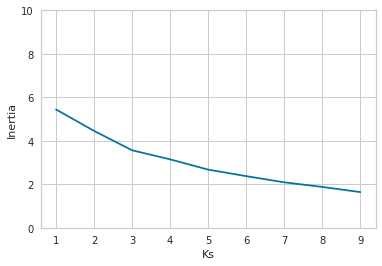

In [29]:
plt.plot(range(1, num_ks), inertias, 'bx-')
plt.xlabel('Ks')
plt.ylabel('Inertia')
plt.ylim(0, 10)
plt.show()

In [30]:
k = 5
KMC = KMeans(n_clusters = k, random_state=0).fit(colleges_clustering)
KMC.labels_

array([0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 3, 0, 0, 0,
       0, 0, 0], dtype=int32)

In [31]:
#top_venue_types.insert(0, 'Cluster', KMC.labels_)
top_venue_types['Cluster'] = KMC.labels_

final_df = colleges_final.join(top_venue_types.set_index('Name'), on='Name')
final_df.head()

,Name,Location,Enrollment,Type,Latitude,Longitude,Venue Category 1,Venue Category 2,Venue Category 3,Venue Category 4,Cluster
0,Bowie State University,Bowie,6171,Public,39.018,-76.759,Jewelry Store,Nightlife Spot,Coffee Shop,College Arts Building,0.0
1,Coppin State University,Baltimore,2724,Public,39.311,-76.659,Sandwich Place,Fast Food Restaurant,Wings Joint,Ethiopian Restaurant,2.0
2,Frostburg State University,Frostburg,4831,Public,39.648,-78.941,NaN,NaN,NaN,NaN,NaN
3,Morgan State University,Baltimore,6616,Public,39.345,-76.584,Hunting Supply,Food Stand,Sandwich Place,Food Service,0.0
4,Salisbury University,Salisbury,8617,Public,38.345,-75.607,Pizza Place,American Restaurant,Fast Food Restaurant,Burger Joint,0.0


In [32]:
cluster_0 = final_df[final_df['Cluster'] == 0]
cluster_0 = cluster_0.drop(['Cluster'], axis=1)
cluster_0

,Name,Location,Enrollment,Type,Latitude,Longitude,Venue Category 1,Venue Category 2,Venue Category 3,Venue Category 4
0,Bowie State University,Bowie,6171,Public,39.018,-76.759,Jewelry Store,Nightlife Spot,Coffee Shop,College Arts Building
3,Morgan State University,Baltimore,6616,Public,39.345,-76.584,Hunting Supply,Food Stand,Sandwich Place,Food Service
4,Salisbury University,Salisbury,8617,Public,38.345,-75.607,Pizza Place,American Restaurant,Fast Food Restaurant,Burger Joint
6,Towson University,Towson,22709,Public,39.390,-76.616,Food Court,College Arts Building,Concert Hall,Pharmacy
7,United States Naval Academy,Annapolis,4400,Public,38.982,-76.483,Food,Gift Shop,History Museum,Historic Site
8,University of Baltimore,Baltimore,4476,Public,39.305,-76.617,Bar,Sandwich Place,Pizza Place,Cupcake Shop
9,"University of Maryland, College Park",College Park,40743,Public,38.992,-76.946,Fast Food Restaurant,Gym / Fitness Center,Gym,Bowling Alley
12,Goucher College,Towson,2680,Private,39.409,-76.593,College Track,Pool,Trail,Disc Golf
13,Hood College,Frederick,2052,Private,39.423,-77.419,Home Service,Fast Food Restaurant,Sandwich Place,Pharmacy
14,Johns Hopkins University,Baltimore,26402,Private,39.330,-76.622,History Museum,Athletics & Sports,Museum,Café


In [33]:
cluster_1 = final_df[final_df['Cluster'] == 1]
cluster_1 = cluster_1.drop(['Cluster'], axis=1)
cluster_1

,Name,Location,Enrollment,Type,Latitude,Longitude,Venue Category 1,Venue Category 2,Venue Category 3,Venue Category 4
18,McDaniel College,Westminster,2845,Private,39.585,-77.004,Coffee Shop,Wings Joint,Farm,Food Court


In [34]:
cluster_2 = final_df[final_df['Cluster'] == 2]
cluster_2 = cluster_2.drop(['Cluster'], axis=1)
cluster_2

,Name,Location,Enrollment,Type,Latitude,Longitude,Venue Category 1,Venue Category 2,Venue Category 3,Venue Category 4
1,Coppin State University,Baltimore,2724,Public,39.311,-76.659,Sandwich Place,Fast Food Restaurant,Wings Joint,Ethiopian Restaurant


In [35]:
cluster_3 = final_df[final_df['Cluster'] == 3]
cluster_3 = cluster_3.drop(['Cluster'], axis=1)
cluster_3

,Name,Location,Enrollment,Type,Latitude,Longitude,Venue Category 1,Venue Category 2,Venue Category 3,Venue Category 4
10,University of Maryland Eastern Shore,Princess Anne,2886,Public,38.214,-75.683,Stadium,Event Space,Food Court,Food


In [36]:
cluster_4 = final_df[final_df['Cluster'] == 4]
cluster_4 = cluster_4.drop(['Cluster'], axis=1)
cluster_4

,Name,Location,Enrollment,Type,Latitude,Longitude,Venue Category 1,Venue Category 2,Venue Category 3,Venue Category 4
5,St. Mary's College of Maryland,St. Mary's City,1849,Public,38.19,-76.425,Pub,Pool,Wings Joint,Event Space


## Plot number of venues versus enrollment

In [37]:
venues_count = college_venues.groupby('Name').count().reset_index()
venues_count = venues_count.loc[:, ['Name', 'Location']]
venues_count = venues_count.rename(columns={'Location': 'Count'})
venues_count.head()

,Name,Count
0,Bowie State University,4
1,Coppin State University,2
2,Goucher College,5
3,Hood College,5
4,Johns Hopkins University,26


In [38]:
plot_df = colleges_df.merge(venues_count, left_on='Name', right_on='Name', how='outer')
plot_df = plot_df.drop(columns=['Latitude', 'Longitude'])
plot_df

,Name,Location,Enrollment,Type,Count
0,Bowie State University,Bowie,6171,Public,4.0
1,Coppin State University,Baltimore,2724,Public,2.0
2,Frostburg State University,Frostburg,4831,Public,NaN
3,Morgan State University,Baltimore,6616,Public,4.0
4,Salisbury University,Salisbury,8617,Public,24.0
5,St. Mary's College of Maryland,St. Mary's City,1849,Public,2.0
6,Towson University,Towson,22709,Public,8.0
7,United States Naval Academy,Annapolis,4400,Public,4.0
8,University of Baltimore,Baltimore,4476,Public,59.0
9,"University of Maryland, Baltimore",Baltimore,6827,Public,28.0


In [39]:
plot_df = plot_df.replace(to_replace={np.nan: 0})
plot_df

,Name,Location,Enrollment,Type,Count
0,Bowie State University,Bowie,6171,Public,4.0
1,Coppin State University,Baltimore,2724,Public,2.0
2,Frostburg State University,Frostburg,4831,Public,0.0
3,Morgan State University,Baltimore,6616,Public,4.0
4,Salisbury University,Salisbury,8617,Public,24.0
5,St. Mary's College of Maryland,St. Mary's City,1849,Public,2.0
6,Towson University,Towson,22709,Public,8.0
7,United States Naval Academy,Annapolis,4400,Public,4.0
8,University of Baltimore,Baltimore,4476,Public,59.0
9,"University of Maryland, Baltimore",Baltimore,6827,Public,28.0


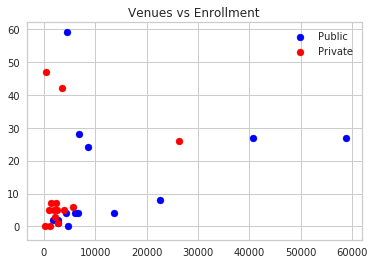

In [41]:
fig, ax = plt.subplots()

public_plot = plot_df.loc[plot_df['Type'] == 'Public']
private_plot = plot_df.loc[plot_df['Type'] == 'Private']

ax.scatter(public_plot['Enrollment'], public_plot['Count'], c='blue', label='Public')
ax.scatter(private_plot['Enrollment'], private_plot['Count'], c='red', label='Private')

ax.set_title('Venues vs Enrollment')
ax.legend()
plt.show()